<font size=6>**AI for Research Proposal Automation**</font>

### **Business Problem - Create an AI system which will help you writing the research proposal aligning with the NOFO Document**
   




Organizations and researchers often maintain large archives of publications and prior work. When responding to competitive grants—especially highly specific ones like NIH NOFOs—it becomes extremely difficult and time-consuming to:

1. Align past work with a new funding call.
2. Extract relevant expertise from unrelated projects.
3. Ideate novel, fundable research proposals tailored to complex criteria.
4. Generate high-quality text for grant submission that satisfies technical and scientific review criteria.

The manual effort to sift through dense research documents, match them to nuanced funding criteria, and write compelling, compliant proposals is labor-intensive, inconsistent, and prone to missed opportunities.

### **The Case Study Approach**

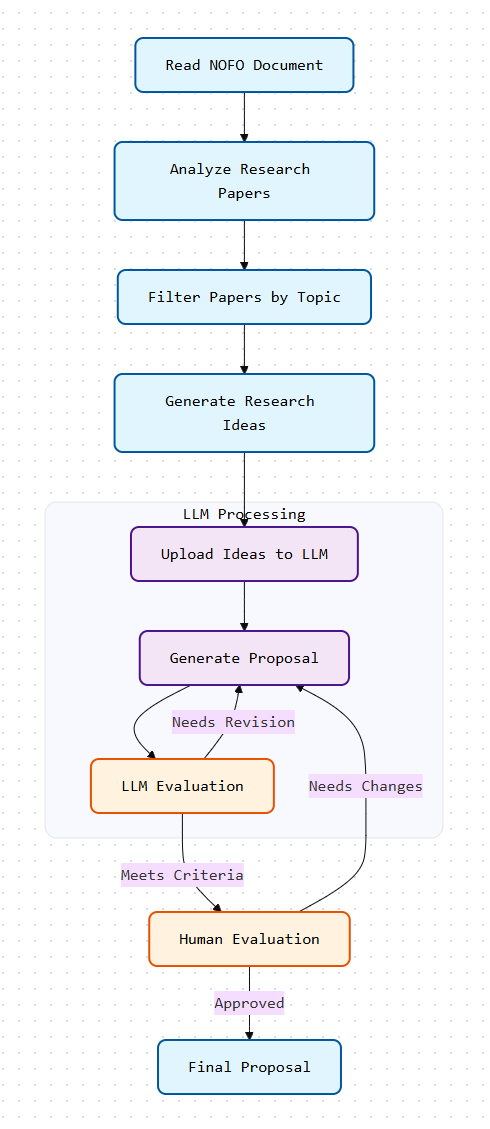

**Objective**
1. Develop a generative AI-powered system using LLMs to automate and optimize the creation of NIH research proposals.
2. The tool will identify relevant prior research, generate aligned project ideas, and draft high-quality proposal content tailored to specific NOFO requirements.

## **Setup**


In [1]:
%pip install -q \
  langchain \
  huggingface-hub \
  openai \
  chromadb \
  langchain-community \
  langchain-openai \
  lark \
  rank_bm25 \
  numpy \
  scipy \
  scikit-learn \
  transformers \
  pypdf \
  markdown-pdf \
  tiktoken \
  sentence-transformers


# PyTorch install line (only if needed, adjust based on your GPU and CUDA version)
!pip install torch==2.6.0 --index-url https://download.pytorch.org/whl/cu124

Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://download.pytorch.org/whl/cu124


In [1]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load environment variables from a JSON file
import json
import os

# Load the JSON file and extract values
file_name = 'config.json'
with open(file_name, 'r') as file:
    config = json.load(file)
    os.environ['OPENAI_API_KEY'] = config.get("API_KEY") # Loading the API Key
    os.environ["OPENAI_BASE_URL"] = config.get("OPENAI_API_BASE") # Loading the API Base Url

In [ ]:
# Defining the LLM Model - Use `gpt-4o-mini` Model
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

## **Step 1: Topic Extraction**

**Read the NOFO doc and identify the topic for which the funding is to be given.**
   

In [4]:
from langchain.document_loaders import PyPDFLoader

# Reading the NOFO Document
pdf_file = r"NOFO.pdf"
pdf_loader = PyPDFLoader(pdf_file);
NOFO_pdf = pdf_loader.load()
full_doc_text = " ".join(page.page_content for page in NOFO_pdf)


Ignoring wrong pointing object 10 0 (offset 0)
Ignoring wrong pointing object 69 0 (offset 0)
Ignoring wrong pointing object 90 0 (offset 0)


Next we write an LLM prompt to extract the Topic for what the funding is been provided from the NOFO document and ask the LLM to respond back with the topic name only and nothing else.

In [5]:
topic_extraction_Prompt = f"""

I want you to act as a topic extraction expert.
Your task is to extract the main topic from the provided text. It is a NOFO document from the NIH.

{full_doc_text}

Respond with the main topic of the document and nothing else.

"""

In [6]:
# Finding the topic for which the Funding is been given
topic_extraction = llm.invoke(topic_extraction_Prompt)
topic = topic_extraction.content
topic

'Funding opportunity for innovative research projects to optimize digital mental health interventions.'

## **Step 2: Research Paper Relevance Assessment**
**Analyze all the Research Papers and filter out the research papers based on the topic of NOFO**


Here we write a Prompt which can be used to analyze the relevance of the provided research paper in relation to the topic outlined in the NOFO (Notice of Funding Opportunity) document. The prompt determines whether the research aligns with the goals, objectives, and funding criteria specified in the NOFO. Additionally, it will assess whether the research paper can be used to support or develop a viable project idea that fits within the scope of the funding opportunity.

<br>

**Note:** If the paper does **not** significantly relate to the topic—by domain, method, theory, or application we ask the LLM to return: **"PAPER NOT RELATED TO TOPIC"**

<br>

The LLM is asked to respond in the below specified structure:

```
### Output Format:
"summary": "<summary of the paper under 300 words, or return: PAPER NOT RELATED TO TOPIC>"

```

In [7]:
relevance_prompt = f"""

You are an expert in evaluating whether academic research papers are **relevant or potentially applicable** to a funding opportunity on digital mental health interventions.

The NIH Notice of Funding Opportunity (NOFO), PAR-25-136: *Laboratories to Optimize Digital Health (R01 Clinical Trial Required)*, is focused on optimizing digital health tools for mental health care, especially for underserved populations.

### ✅ WHEN TO MARK A PAPER AS RELEVANT

Mark the paper as **RELEVANT** if it either:

1. **Explicitly** focuses on:
   - Digital health tools (e.g., mobile apps, wearables, EHR systems, chatbots, telehealth)
   - Mental health outcomes (e.g., anxiety, depression, PTSD, emotional well-being)
   - Clinical trials or real-world implementation for health interventions
   - Reducing disparities or targeting vulnerable populations

**OR**

2. **Could be applied** to digital mental health based on its:
   - Social media analysis of human behavior, communities, or discourse
   - Neuroscience, biosensing, or brain-computer interfaces relevant to emotional states
   - Machine learning or NLP methods that could support health-related behavior analysis
   - Multi-agent systems, network models, or human-AI interaction platforms that could inform scalable digital health interventions

Even if the study is not *yet* applied to mental health, if it **could plausibly be extended or adapted**, it is **relevant**.

---

### ❌ WHEN TO MARK AS NOT RELEVANT

Mark it **not relevant** if it:
- Focuses on physical health, epidemiology, or unrelated diseases (e.g., HIV, cancer)
- Involves general social computing with no link to mental or emotional well-being
- Is purely theoretical with no plausible path to health-related use
- Lacks any mention or implication of health, well-being, digital intervention, or vulnerable groups

---

### REQUIRED OUTPUT FORMAT

Respond with exactly one of the following:

**If relevant or plausibly applicable:**

"summary": "Author(s): [Insert full name(s) or 'Unknown'], Year of Publication: [Insert year or 'n.d.'], Summary: [Concise description of the paper’s
 objectives, methods, findings, and a final statement explaining why it’s relevant or applicable to digital mental health]."

**If not relevant:**

"summary": "PAPER NOT RELATED TO TOPIC"

Keep the summary under 300 words. If unsure, include it and explain why it might apply.

---

### Research Paper Context:
"""


In [8]:
import tiktoken

# Reading all PDF files and storing it in 1 variable
path = "ResearchPapers\Papers"
documents = []
total_files  = len(os.listdir(path))

# Defining the max tokens to avoid error for context being to long
encoding = tiktoken.encoding_for_model("gpt-4o-mini")
MAX_TOKENS = 127500

progress_cnt = 1
relevant_papers_count = 0
irrelevant_papers_count = 0

for filename in os.listdir(path):
    if filename.endswith('.pdf'):
        file_path = os.path.join(path, filename)

        try:
            # Load PDF
            docs = PyPDFLoader(file_path,mode="single").load()
            # extracting the pages
            pages = docs[0].page_content

            # combining the prompt with the pages of the research paper within the context length
            available_tokens = MAX_TOKENS - len(encoding.encode(relevance_prompt ))
            truncated_pages = encoding.decode(encoding.encode(pages)[:available_tokens])
            full_prompt = relevance_prompt + truncated_pages

            # Calling the LLM
            response = llm.invoke(full_prompt)

            print(f"Successfully processed: {progress_cnt}/{total_files}")
            progress_cnt += 1

            #  If the paper is not relevant skipping the paper
            if  "PAPER NOT RELATED TO TOPIC" in response.content:
              irrelevant_papers_count += 1
              continue

            #  If the paper is relevant adding it to the documents variable
            documents.append({ 'title': filename, 'llm_response': response.content, 'file_path':file_path})
            relevant_papers_count += 1

        except Exception as e:
            print(f"!!! Error processing {filename}: {str(e)}")


print("="*50)
print(f"Relevant Papers: {relevant_papers_count}/{total_files}")
print(f"Irrelevant Papers: {irrelevant_papers_count}/{total_files}")



Successfully processed: 1/111
Successfully processed: 2/111


Ignoring wrong pointing object 9 0 (offset 0)
Ignoring wrong pointing object 51 0 (offset 0)
Ignoring wrong pointing object 54 0 (offset 0)
Ignoring wrong pointing object 56 0 (offset 0)


Successfully processed: 3/111
Successfully processed: 4/111
Successfully processed: 5/111
Successfully processed: 6/111
Successfully processed: 7/111
Successfully processed: 8/111
Successfully processed: 9/111
Successfully processed: 10/111
Successfully processed: 11/111
Successfully processed: 12/111
Successfully processed: 13/111


Ignoring wrong pointing object 83 0 (offset 0)


Successfully processed: 14/111
Successfully processed: 15/111
Successfully processed: 16/111
Successfully processed: 17/111
Successfully processed: 18/111


Ignoring wrong pointing object 8 0 (offset 0)
Ignoring wrong pointing object 10 0 (offset 0)
Ignoring wrong pointing object 12 0 (offset 0)
Ignoring wrong pointing object 14 0 (offset 0)
Ignoring wrong pointing object 16 0 (offset 0)
Ignoring wrong pointing object 18 0 (offset 0)
Ignoring wrong pointing object 26 0 (offset 0)
Ignoring wrong pointing object 28 0 (offset 0)
Ignoring wrong pointing object 38 0 (offset 0)


Successfully processed: 19/111
Successfully processed: 20/111
Successfully processed: 21/111


Ignoring wrong pointing object 18 0 (offset 0)
Ignoring wrong pointing object 20 0 (offset 0)
Ignoring wrong pointing object 48 0 (offset 0)
Ignoring wrong pointing object 92 0 (offset 0)


Successfully processed: 22/111
Successfully processed: 23/111


Ignoring wrong pointing object 50 0 (offset 0)


Successfully processed: 24/111
Successfully processed: 25/111
Successfully processed: 26/111
Successfully processed: 27/111


Ignoring wrong pointing object 8 0 (offset 0)
Ignoring wrong pointing object 10 0 (offset 0)
Ignoring wrong pointing object 12 0 (offset 0)
Ignoring wrong pointing object 14 0 (offset 0)
Ignoring wrong pointing object 16 0 (offset 0)


Successfully processed: 28/111
Successfully processed: 29/111
Successfully processed: 30/111
Successfully processed: 31/111


Ignoring wrong pointing object 8 0 (offset 0)
Ignoring wrong pointing object 10 0 (offset 0)
Ignoring wrong pointing object 12 0 (offset 0)
Ignoring wrong pointing object 14 0 (offset 0)
Ignoring wrong pointing object 16 0 (offset 0)
Ignoring wrong pointing object 18 0 (offset 0)
Ignoring wrong pointing object 28 0 (offset 0)


Successfully processed: 32/111


Ignoring wrong pointing object 8 0 (offset 0)
Ignoring wrong pointing object 11 0 (offset 0)
Ignoring wrong pointing object 14 0 (offset 0)
Ignoring wrong pointing object 34 0 (offset 0)
Ignoring wrong pointing object 47 0 (offset 0)


Successfully processed: 33/111


Ignoring wrong pointing object 6 0 (offset 0)
Ignoring wrong pointing object 8 0 (offset 0)
Ignoring wrong pointing object 10 0 (offset 0)
Ignoring wrong pointing object 12 0 (offset 0)
Ignoring wrong pointing object 36 0 (offset 0)
Ignoring wrong pointing object 38 0 (offset 0)
Ignoring wrong pointing object 40 0 (offset 0)
Ignoring wrong pointing object 42 0 (offset 0)
Ignoring wrong pointing object 52 0 (offset 0)
Ignoring wrong pointing object 54 0 (offset 0)


Successfully processed: 34/111
Successfully processed: 35/111


Ignoring wrong pointing object 8 0 (offset 0)
Ignoring wrong pointing object 10 0 (offset 0)
Ignoring wrong pointing object 13 0 (offset 0)
Ignoring wrong pointing object 22 0 (offset 0)
Ignoring wrong pointing object 24 0 (offset 0)
Ignoring wrong pointing object 27 0 (offset 0)


Successfully processed: 36/111
Successfully processed: 37/111
Successfully processed: 38/111
Successfully processed: 39/111


Multiple definitions in dictionary at byte 0x8fa1a for key /PageMode


Successfully processed: 40/111
Successfully processed: 41/111
Successfully processed: 42/111
Successfully processed: 43/111
Successfully processed: 44/111
Successfully processed: 45/111
Successfully processed: 46/111


Ignoring wrong pointing object 8 0 (offset 0)
Ignoring wrong pointing object 10 0 (offset 0)
Ignoring wrong pointing object 12 0 (offset 0)
Ignoring wrong pointing object 14 0 (offset 0)
Ignoring wrong pointing object 16 0 (offset 0)
Ignoring wrong pointing object 25 0 (offset 0)
Ignoring wrong pointing object 35 0 (offset 0)
Ignoring wrong pointing object 37 0 (offset 0)
Ignoring wrong pointing object 39 0 (offset 0)
Ignoring wrong pointing object 41 0 (offset 0)
Ignoring wrong pointing object 43 0 (offset 0)
Ignoring wrong pointing object 45 0 (offset 0)
Ignoring wrong pointing object 53 0 (offset 0)
Ignoring wrong pointing object 55 0 (offset 0)
Ignoring wrong pointing object 57 0 (offset 0)
Ignoring wrong pointing object 59 0 (offset 0)
Ignoring wrong pointing object 61 0 (offset 0)


Successfully processed: 47/111
Successfully processed: 48/111
Successfully processed: 49/111


Ignoring wrong pointing object 8 0 (offset 0)
Ignoring wrong pointing object 10 0 (offset 0)
Ignoring wrong pointing object 12 0 (offset 0)
Ignoring wrong pointing object 40 0 (offset 0)


Successfully processed: 50/111
Successfully processed: 51/111
Successfully processed: 52/111
Successfully processed: 53/111
Successfully processed: 54/111
Successfully processed: 55/111
Successfully processed: 56/111
Successfully processed: 57/111
Successfully processed: 58/111
Successfully processed: 59/111
Successfully processed: 60/111


Ignoring wrong pointing object 21 0 (offset 0)
Ignoring wrong pointing object 23 0 (offset 0)
Ignoring wrong pointing object 27 0 (offset 0)
Ignoring wrong pointing object 29 0 (offset 0)
Ignoring wrong pointing object 41 0 (offset 0)
Ignoring wrong pointing object 43 0 (offset 0)
Ignoring wrong pointing object 52 0 (offset 0)


Successfully processed: 61/111
Successfully processed: 62/111
Successfully processed: 63/111


Ignoring wrong pointing object 8 0 (offset 0)
Ignoring wrong pointing object 12 0 (offset 0)
Ignoring wrong pointing object 14 0 (offset 0)
Ignoring wrong pointing object 16 0 (offset 0)
Ignoring wrong pointing object 26 0 (offset 0)
Ignoring wrong pointing object 28 0 (offset 0)


Successfully processed: 64/111
Successfully processed: 65/111
Successfully processed: 66/111


Ignoring wrong pointing object 11 0 (offset 0)
Ignoring wrong pointing object 13 0 (offset 0)
Ignoring wrong pointing object 58 0 (offset 0)
Ignoring wrong pointing object 69 0 (offset 0)
Ignoring wrong pointing object 71 0 (offset 0)
Ignoring wrong pointing object 73 0 (offset 0)
Ignoring wrong pointing object 75 0 (offset 0)
Ignoring wrong pointing object 88 0 (offset 0)
Ignoring wrong pointing object 90 0 (offset 0)
Ignoring wrong pointing object 96 0 (offset 0)
Ignoring wrong pointing object 98 0 (offset 0)
Ignoring wrong pointing object 141 0 (offset 0)
Ignoring wrong pointing object 143 0 (offset 0)
Ignoring wrong pointing object 150 0 (offset 0)
Ignoring wrong pointing object 156 0 (offset 0)
Ignoring wrong pointing object 191 0 (offset 0)
Ignoring wrong pointing object 193 0 (offset 0)
Ignoring wrong pointing object 200 0 (offset 0)
Ignoring wrong pointing object 206 0 (offset 0)
Ignoring wrong pointing object 249 0 (offset 0)
Ignoring wrong pointing object 251 0 (offset 0)
Ign

Successfully processed: 67/111
Successfully processed: 68/111
Successfully processed: 69/111


Ignoring wrong pointing object 10 0 (offset 0)
Ignoring wrong pointing object 15 0 (offset 0)
Ignoring wrong pointing object 19 0 (offset 0)
Ignoring wrong pointing object 30 0 (offset 0)
Ignoring wrong pointing object 32 0 (offset 0)
Ignoring wrong pointing object 44 0 (offset 0)


Successfully processed: 70/111
Successfully processed: 71/111
Successfully processed: 72/111
Successfully processed: 73/111


Ignoring wrong pointing object 8 0 (offset 0)
Ignoring wrong pointing object 10 0 (offset 0)
Ignoring wrong pointing object 12 0 (offset 0)
Ignoring wrong pointing object 20 0 (offset 0)
Ignoring wrong pointing object 26 0 (offset 0)
Ignoring wrong pointing object 39 0 (offset 0)
Ignoring wrong pointing object 41 0 (offset 0)


Successfully processed: 74/111
Successfully processed: 75/111
Successfully processed: 76/111
Successfully processed: 77/111
Successfully processed: 78/111


Ignoring wrong pointing object 8 0 (offset 0)
Ignoring wrong pointing object 14 0 (offset 0)
Ignoring wrong pointing object 16 0 (offset 0)
Ignoring wrong pointing object 25 0 (offset 0)
Ignoring wrong pointing object 27 0 (offset 0)


Successfully processed: 79/111
Successfully processed: 80/111
Successfully processed: 81/111
Successfully processed: 82/111
Successfully processed: 83/111
Successfully processed: 84/111


Ignoring wrong pointing object 8 0 (offset 0)
Ignoring wrong pointing object 10 0 (offset 0)
Ignoring wrong pointing object 12 0 (offset 0)
Ignoring wrong pointing object 27 0 (offset 0)
Ignoring wrong pointing object 68 0 (offset 0)


Successfully processed: 85/111
Successfully processed: 86/111
Successfully processed: 87/111


Ignoring wrong pointing object 8 0 (offset 0)
Ignoring wrong pointing object 10 0 (offset 0)
Ignoring wrong pointing object 13 0 (offset 0)
Ignoring wrong pointing object 22 0 (offset 0)
Ignoring wrong pointing object 24 0 (offset 0)
Ignoring wrong pointing object 27 0 (offset 0)


Successfully processed: 88/111
Successfully processed: 89/111


Ignoring wrong pointing object 8 0 (offset 0)
Ignoring wrong pointing object 10 0 (offset 0)
Ignoring wrong pointing object 24 0 (offset 0)
Ignoring wrong pointing object 38 0 (offset 0)


Successfully processed: 90/111


Ignoring wrong pointing object 8 0 (offset 0)
Ignoring wrong pointing object 10 0 (offset 0)
Ignoring wrong pointing object 12 0 (offset 0)
Ignoring wrong pointing object 14 0 (offset 0)
Ignoring wrong pointing object 16 0 (offset 0)


Successfully processed: 91/111
Successfully processed: 92/111
Successfully processed: 93/111
Successfully processed: 94/111
Successfully processed: 95/111
Successfully processed: 96/111
Successfully processed: 97/111
Successfully processed: 98/111


Ignoring wrong pointing object 6 0 (offset 0)
Ignoring wrong pointing object 15 0 (offset 0)
Ignoring wrong pointing object 26 0 (offset 0)


Successfully processed: 99/111
Successfully processed: 100/111
Successfully processed: 101/111
Successfully processed: 102/111
Successfully processed: 103/111
Successfully processed: 104/111
Successfully processed: 105/111
Successfully processed: 106/111
Successfully processed: 107/111
Successfully processed: 108/111
Successfully processed: 109/111
Successfully processed: 110/111
Successfully processed: 111/111
Relevant Papers: 78/111
Irrelevant Papers: 33/111


In [9]:
import re
import os

# Assuming `documents` is your list of dictionaries
relevant_documents = ""

for doc in documents:
    title = doc.get("title", "Unknown Title")
    file_path = doc.get("file_path", "Unknown Path")
    llm_response = doc.get("llm_response", "")

    # Extract the full summary string
    match = re.search(r'"summary":\s*"(.+?)"', llm_response, re.DOTALL)
    summary_text = match.group(1).strip() if match else "No summary available."

    # Extract Author(s)
    author_match = re.search(r'Author\(s\):\s*(.*?),\s*Year of Publication:', summary_text)
    author_text = author_match.group(1).strip() if author_match else None

    # Extract Year of Publication
    year_match = re.search(r'Year of Publication:\s*(\d{4})', summary_text)
    year_text = year_match.group(1).strip() if year_match else None

    # Construct citation
    if author_text and year_text:
        citation = f"{author_text}, {year_text}"
    elif author_text:
        citation = f"{author_text}, n.d."
    elif year_text:
        citation = f"{title}, {year_text}"
    else:
        citation = title

    # Append to the text blob
    relevant_documents += (
        f"**Title:** {title}\n"
        f"**Citation:** {citation}\n"
        f"**Summary:** {summary_text}\n"
        f"**File Path:** {file_path}\n"
        f"{'-'*60}\n\n"
    )

# Preview the first 1000 characters
print(relevant_documents[:2000])


**Title:** 2021_EPJ_MVMCInfoOps.pdf
**Citation:** Joshua Uyheng, Iain J. Cruickshank, Kathleen M. Carley, 2023
**Summary:** Author(s): Joshua Uyheng, Iain J. Cruickshank, Kathleen M. Carley, Year of Publication: 2023, Summary: This paper presents a computational framework for mapping state-sponsored information operations using multi-view modularity clustering (MVMC). The authors analyze Chinese state-sponsored accounts on Twitter, revealing how these accounts engage in coordinated narrative and network maneuvers to manage China's international reputation, particularly during the COVID-19 pandemic. The study identifies distinct clusters of accounts that employ various strategies, including discrediting critics and promoting national solidarity. The findings highlight the potential for using unsupervised methods to understand complex digital campaigns, making it relevant to digital mental health interventions by illustrating how social media dynamics can influence public perception and 

## **Step 3: Proposal Ideation Based on Filtered Research**
**Use the filtered papers, to generate ideas for the Reseach Proposal.**


Here we write a Prompt which can be used to generate 5 ideas for the Research Proposal, where each idea has this format:

1. **Idea X:** [Concise Title of the Project Idea]
2. **Description:** [Brief and targeted description summarizing the objectives, innovative elements, scientific rationale, and anticipated impact.]
3. **Citation:** [Author(s), Year or Paper Title]
4. **NOFO Alignment:** [List two or more specific NOFO requirements that this idea directly addresses]
5. **File Path of the Research Paper:** [Exact file path, ending in .pdf]

- Use the Delimiter `---` for defining the structure of the sample outputs in the prompt





In [10]:
gen_idea_prompt = f"""


You are a research strategist assisting with NIH grant development. You will read through the **Relevant Documents** provided and generate 5 proposal 
ideas aligned with the NIH Notice of Funding Opportunity (NOFO):

**PAR-25-136: Laboratories to Optimize Digital Health (R01 Clinical Trial Required)**

Your output should consist of 5 distinct ideas. Each idea must:
1. Be concise but innovative.
2. Address at least two clear NOFO criteria (as listed in PAR-25-136).
3. Be suitable for digital mental health research with clinical trial potential.
4. Include a brief but relevant citation of the research paper being analyzed, formatted as: Author(s), Year or Paper Title.

The following is a list of NOFO criteria drawn from NIH PAR-25-136:

1. Must use existing, high-traffic digital mental health platforms (≥1,000 users).
2. Target vulnerable populations and reduce mental health disparities.
3. Propose clinical trials powered to test effectiveness.
4. Include adaptive, just-in-time interventions (e.g., mobile, wearable-triggered).
5. Study not just "what works" but "why it works" (mechanisms of action).
6. Avoid simple digitization of face-to-face treatments.
7. Go beyond basic trials—include algorithms, ML, personalization, etc.
8. Address known challenges in engagement, adherence, or uptake.
9. Integrate with real-time systems (EHRs, apps, sensors).
10. Ensure stakeholder collaboration in study design and interpretation.

You must align each project idea to at least two of these criteria. State in words the criteria you are addressing in each idea.

For each idea, you must strictly follow the structure below and use the delimiter `---` to separate entries.

Here is the output format for each idea:

---

**Idea X:** [Concise Title of the Project Idea]  

**Description:** [Brief and targeted description summarizing the objectives, innovative elements, scientific rationale, and anticipated impact.] 

**Citation:** [Author(s), Year or Paper Title]  

**NOFO Alignment:** [List two or more specific NOFO requirements that this idea directly addresses]  

**File Path of the Research Paper:** [Exact file path, ending in .pdf]

---

Here are the **Relevant Documents** you will use to generate the ideas:  
{relevant_documents}  
Use academic tone, avoid repetition, and emphasize originality and feasibility. Ensure that your proposals are deployment-focused, evidence-informed, and considerate of vulnerable or underserved populations.
"""


In [11]:
ideas = llm.invoke(gen_idea_prompt)

In [12]:
from IPython.display import Markdown, display
display(Markdown(ideas.content))

---

**Idea 1:** Enhancing Mental Health Engagement through Adaptive Social Media Interventions  

**Description:** This project aims to develop a digital mental health intervention that leverages existing high-traffic social media platforms to deliver adaptive, just-in-time interventions for vulnerable populations. By utilizing machine learning algorithms to analyze user engagement patterns and sentiment, the intervention will provide personalized mental health resources and support based on real-time user data. The study will include a clinical trial to assess the effectiveness of these interventions in improving mental health outcomes and engagement rates among underserved communities.  

**Citation:** Ian McCulloh, 2023, "Social Media Mental Health Final"  

**NOFO Alignment:** 1. Must use existing, high-traffic digital mental health platforms (≥1,000 users). 4. Include adaptive, just-in-time interventions (e.g., mobile, wearable-triggered). 3. Propose clinical trials powered to test effectiveness.  

**File Path of the Research Paper:** ResearchPapers\Papers\Social Media Mental Health Final.pdf  

---

**Idea 2:** AI-Driven Misinformation Mitigation in Digital Mental Health  

**Description:** This proposal seeks to develop an AI-driven tool that detects and mitigates misinformation related to mental health on social media platforms. By employing natural language processing techniques, the tool will analyze user-generated content to identify harmful narratives and provide counter-messaging in real-time. The project will include a clinical trial to evaluate the tool's effectiveness in reducing anxiety and misinformation-related distress among vulnerable populations, particularly during crises.  

**Citation:** David Farr, Lynnette Hui Xian Ng, Stephen Prochaska, Iain J. Cruickshank, Jevin West, 2025, "Misinformation Simulation"  

**NOFO Alignment:** 2. Target vulnerable populations and reduce mental health disparities. 8. Address known challenges in engagement, adherence, or uptake. 3. Propose clinical trials powered to test effectiveness.  

**File Path of the Research Paper:** ResearchPapers\Papers\Misinformation_Simulation.pdf  

---

**Idea 3:** Neurofeedback-Based Digital Interventions for Anxiety Management  

**Description:** This project proposes the development of a digital platform that integrates neurofeedback technology to help users manage anxiety through real-time monitoring of physiological responses. By utilizing wearable devices, the platform will provide personalized interventions based on users' neurophysiological data, enhancing engagement and adherence. A clinical trial will assess the platform's effectiveness in reducing anxiety symptoms among underserved populations, particularly those with limited access to traditional mental health services.  

**Citation:** Macrina C. Dieffenbach, Grace S. R. Gillespie, Shannon M. Burns, Ian A. McCulloh, et al., 2021, "NeuroSynchrony"  

**NOFO Alignment:** 4. Include adaptive, just-in-time interventions (e.g., mobile, wearable-triggered). 3. Propose clinical trials powered to test effectiveness. 2. Target vulnerable populations and reduce mental health disparities.  

**File Path of the Research Paper:** ResearchPapers\Papers\NeuroSynchrony.pdf  

---

**Idea 4:** Community-Driven Digital Mental Health Support Networks  

**Description:** This initiative aims to create a digital platform that fosters community-driven support networks for mental health, particularly targeting underserved populations. By utilizing social network analysis and machine learning, the platform will identify key community influencers and facilitate peer support interactions. The project will include a clinical trial to evaluate the platform's impact on mental health outcomes and community engagement, focusing on reducing stigma and improving access to mental health resources.  

**Citation:** Ian McCulloh, 2013, "Vol33Iss1_INSNApdf"  

**NOFO Alignment:** 2. Target vulnerable populations and reduce mental health disparities. 10. Ensure stakeholder collaboration in study design and interpretation. 3. Propose clinical trials powered to test effectiveness.  

**File Path of the Research Paper:** ResearchPapers\Papers\Vol33Iss1_INSNApdf.pdf  

---

**Idea 5:** Personalized Mental Health Interventions Using AI and Social Media Analytics  

**Description:** This project proposes the development of a personalized mental health intervention platform that utilizes AI to analyze social media interactions and sentiment. By identifying users' emotional states and engagement patterns, the platform will deliver tailored mental health resources and interventions. A clinical trial will assess the effectiveness of these personalized interventions in improving mental health outcomes among vulnerable populations, particularly those affected by social isolation and stigma.  

**Citation:** Iain J. Cruickshank, Lynnette Hui Xian Ng, 2023, "ICWSM___Use_of_Large_Language_Models_for_Stance_Classification"  

**NOFO Alignment:** 1. Must use existing, high-traffic digital mental health platforms (≥1,000 users). 7. Go beyond basic trials—include algorithms, ML, personalization, etc. 3. Propose clinical trials powered to test effectiveness.  

**File Path of the Research Paper:** ResearchPapers\Papers\ICWSM___Use_of_Large_Language_Models_for_Stance_Classification.pdf  

---

In [13]:
# Modify the idea_number for choosing the different idea
idea_number = 4   # change the number if you wish to choose and generate the research proposal for another idea
chosen_idea = ideas.content.split("---")[idea_number]

In [ ]:
import re

# Use a regular expression to find the file path of the research paper

pattern = r"File Path of the Research Paper:\*\*\s*(.+?)\n"

match = re.search(pattern, chosen_idea)

if match:
  idea_generated_from_research_paper = match.group(1).strip()
  print("Filepath : ", idea_generated_from_research_paper)
else:
  print("File Path of the Research Paper not found in the chosen idea.")


Filepath :  ResearchPapers\Papers\Vol33Iss1_INSNApdf.pdf


## **Step 4: Proposal Blueprint Preparation**

**Select appropriate research ideas for the proposal and supply 'Sample Research Proposals' as templates to the LLM to support the generation of the final proposal.**

Here we write a prompt which can be used to generate the Research Proposal.

The prompt should be able to craft a research proposal based on the sample research proposal template, using one of the ideas generated above. The proposal should include references to the actual research papers from which the ideas are derived and should align well with the NOFO documents.

In [ ]:
# Here we need to add the full paper instead of the summary
chosen_idea_rp = PyPDFLoader(idea_generated_from_research_paper, mode="single").load()

# Loading the sample research proposal template
research_proposal_template = PyPDFLoader( r"Research Proposal Template.pdf" , mode="single").load()


In [17]:
research_proposal_template_prompt = f"""


You are a grant proposal writing assistant with expertise in NIH funding mechanisms and digital mental health research.

Your task is to draft a full research proposal using the **provided research proposal template** as a structural guide. The proposal must be based 
on the **selected idea** and must draw from the full **research paper** used to justify the idea. Additionally, the proposal must demonstrate strong 
alignment with the NIH **Notice of Funding Opportunity (NOFO)** PAR-25-136, using its stated goals and requirements.

## INPUTS:

- **Research Idea:**  
{chosen_idea}

- **Research Paper (Full Text):**  
{chosen_idea_rp}

- **Notice of Funding Opportunity (PAR-25-136):**  
{NOFO_pdf}

- **Proposal Template to Follow:**  
{research_proposal_template}

## INSTRUCTIONS:

Using the research proposal template provided, write a complete proposal that:

1. Clearly presents the idea’s background, objectives, innovation, and methods.
2. Explicitly references and incorporates insights from the selected research paper.
3. Demonstrates alignment with at least **two specific NOFO criteria**, quoting them where appropriate.
4. Uses professional, persuasive, and academically rigorous language suitable for NIH R01 grant submissions.
5. Includes a citation of the research paper used, placed where it naturally fits within the proposal.

Be sure to customize all sections of the proposal with content grounded in the research paper and the NOFO context. Maintain a logical flow and 
ensure that the proposal is self-contained and compelling.

Begin writing the full proposal now.


"""

In [18]:
research_plan = llm.invoke(research_proposal_template_prompt)

In [19]:
display(Markdown(research_plan.content))

# Research Proposal: Community-Driven Digital Mental Health Support Networks

## 1. Introduction

Mental health disorders are prevalent across diverse populations, yet access to effective mental health resources remains a significant challenge, particularly for underserved communities. The National Institute of Mental Health (NIMH) reports that approximately one in five adults in the U.S. experiences mental illness, but many do not receive the necessary care (NIMH, 2024). This disparity is exacerbated in vulnerable populations, including racial and ethnic minorities, who often face barriers such as stigma, lack of resources, and inadequate access to care. 

To address these challenges, we propose the development of a community-driven digital mental health support network. This initiative aims to create a digital platform that fosters peer support interactions, leveraging social network analysis and machine learning to identify key community influencers. By facilitating connections among individuals seeking mental health support, we aim to reduce stigma, enhance community engagement, and improve access to mental health resources.

## 2. Problem Statement

Despite the increasing availability of digital mental health interventions, many individuals, particularly in underserved communities, remain unaware of or unable to access these resources. The existing literature highlights the importance of social networks in influencing mental health behaviors and attitudes (McCulloh, 2013). However, there is a lack of structured approaches to harness these networks effectively for mental health support. Our research seeks to address the following questions:

1. How can community-driven digital platforms effectively connect individuals seeking mental health support?
2. What role do community influencers play in shaping attitudes towards mental health and facilitating access to resources?
3. How can we measure the impact of these digital support networks on mental health outcomes and community engagement?

## 3. Objectives

The primary objective of this research is to develop and evaluate a digital platform that facilitates community-driven mental health support networks. Specifically, we aim to:

1. Identify and engage community influencers who can promote mental health resources and reduce stigma.
2. Develop a digital platform that enables peer support interactions and resource sharing.
3. Conduct a clinical trial to evaluate the platform's effectiveness in improving mental health outcomes and community engagement.

The anticipated outcomes of this research include increased awareness of mental health resources, enhanced community support, and improved mental health outcomes among participants.

## 4. Preliminary Literature Review

Previous studies have demonstrated the efficacy of digital health interventions in improving mental health outcomes (NIMH, 2024). However, many of these interventions have not effectively reached vulnerable populations. McCulloh (2013) emphasizes the significance of social networks in influencing conformity and behavior, suggesting that leveraging these networks can enhance the effectiveness of mental health interventions. 

Despite the promising potential of digital platforms, there is a notable gap in research focusing on community-driven approaches that engage local influencers and foster peer support. Our proposed study aims to fill this gap by integrating social network analysis and machine learning to create a tailored digital platform that addresses the unique needs of underserved populations.

## 5. Methodology

### 5.1 Study Design

We will employ a mixed-methods approach, combining qualitative and quantitative research methods. The study will consist of three phases:

1. **Phase 1: Community Engagement and Influencer Identification**
   - Conduct focus groups and interviews with community members to identify key influencers and understand barriers to mental health resource access.
   - Utilize social network analysis to map community connections and identify potential influencers.

2. **Phase 2: Platform Development**
   - Develop a digital platform that facilitates peer support interactions, resource sharing, and community engagement.
   - Incorporate machine learning algorithms to personalize user experiences and enhance engagement.

3. **Phase 3: Clinical Trial**
   - Conduct a randomized controlled trial to evaluate the platform's effectiveness in improving mental health outcomes and community engagement.
   - Measure outcomes using validated mental health assessments and community engagement metrics.

### 5.2 Data Analysis

Data will be analyzed using statistical methods appropriate for clinical trials, including regression analysis to assess the impact of the intervention on mental health outcomes. Qualitative data from focus groups will be analyzed thematically to identify common barriers and facilitators to mental health resource access.

## 6. Innovation

This research is innovative in its approach to integrating community-driven strategies with digital health interventions. By leveraging social network analysis and machine learning, we aim to create a platform that not only connects individuals with mental health resources but also empowers community members to take an active role in promoting mental health awareness. This aligns with the NIMH's goal to "test strategies to increase the reach, efficiency, effectiveness, and quality of digital mental health interventions" (NIMH, 2024).

## 7. Conclusion

The proposed community-driven digital mental health support network has the potential to significantly impact mental health outcomes among underserved populations. By engaging community influencers and fostering peer support, we aim to reduce stigma, enhance access to resources, and improve overall mental health. This research aligns with the NIMH's mission to transform the understanding and treatment of mental illnesses and addresses critical gaps in current mental health interventions.

## References

McCulloh, I. (2013). Social Conformity in Networks. *Connections*, 33(1), 1-10.

National Institute of Mental Health (NIMH). (2024). Mental Illness. Retrieved from [NIMH website](https://www.nimh.nih.gov/health/statistics/mental-illness). 

---

This proposal is designed to meet the requirements outlined in the NIH Notice of Funding Opportunity PAR-25-136, specifically targeting vulnerable populations and reducing mental health disparities while ensuring stakeholder collaboration in study design and interpretation.

In [ ]:
# Optional - Creating a PDF of the Research Proposal
# The code in this cell block is used for printing out the output in the PDF format
from markdown_pdf import MarkdownPdf, Section

pdf = MarkdownPdf()
pdf.add_section(Section(research_plan.content))
pdf.save("Reseach Proposal First Draft.pdf")

from pypdf import PdfReader

# Load the saved PDF
pdf_path = "Reseach Proposal First Draft.pdf"
reader = PdfReader(pdf_path)

# Extract all text
proposal_text = ""
for page in reader.pages:
    proposal_text += page.extract_text() + "\n"


## **Step 5: Proposal Evaluation Against NOFO Criteria**
**Use the LLM to evaluate the generated proposal (LLM-as-Judge) and assess its alignment with the NOFO criteria.**

Here we write a prompt which can be used to evaluate the Research Proposal based on:
1. **Innovation**
2. **Significance**
3. **Approach**
4. **Investigator Expertise**

- Ask the LLM to rate on each of the criteria from **1 (Poor)** to **5 (Excellent)**
- Ask the LLM to provide the resonse in the json format
- Edit evaluation criteria 1-4 as desired

In [22]:
evaluation_prompt = f"""
You are an NIH grant review panelist evaluating research proposals submitted under the Notice of Funding Opportunity (NOFO):  
**PAR-25-136: Laboratories to Optimize Digital Health (R01 Clinical Trial Required).**

Your task is to assess the following research proposal based on both its content and its alignment with the NOFO criteria.

### Your Evaluation Criteria:

1. **Innovation** – How novel is the approach, technology, or application?
2. **Significance** – How important is the problem being addressed? How impactful is the proposed solution?
3. **Approach** – How strong is the study design, methodology, and overall feasibility?
4. **Investigator Expertise** – How well-positioned is the team to carry out this research?

### Scoring:
Rate each category on a scale from **1 (Poor)** to **5 (Excellent)**.

### Output Format (strictly follow this JSON format):
```json
[
  {{
    "name": "Innovation",
    "justification": "<Your reasoning here>",
    "score": <1-5>,
    "strengths": "<At least one strength>",
    "weaknesses": "<At least one weakness>",
    "recommendations": "<One actionable suggestion>"
  }},
  {{
    "name": "Significance",
    "justification": "<Your reasoning here>",
    "score": <1-5>,
    "strengths": "<At least one strength>",
    "weaknesses": "<At least one weakness>",
    "recommendations": "<One actionable suggestion>"
  }},
  {{
    "name": "Approach",
    "justification": "<Your reasoning here>",
    "score": <1-5>,
    "strengths": "<At least one strength>",
    "weaknesses": "<At least one weakness>",
    "recommendations": "<One actionable suggestion>"
  }},
  {{
    "name": "Investigator Expertise",
    "justification": "<Your reasoning here>",
    "score": <1-5>,
    "strengths": "<At least one strength>",
    "weaknesses": "<At least one weakness>",
    "recommendations": "<One actionable suggestion>"
  }}
]

Research Proposal Text:
{proposal_text}

NOFO Document (PAR-25-136):
{NOFO_pdf}

Please review the proposal in the context of the NOFO criteria and return your evaluation in the exact JSON format provided above. Do not include 
any explanation outside the JSON.

"""

In [23]:
eval_response = llm.invoke(evaluation_prompt)

In [24]:
import json
json_resp = json.loads(eval_response.content[7:-3])

In [25]:
for criterion in json_resp:
    print(f"---\n{criterion['name']}:")
    for k, v in criterion.items():
        if k != "name":
            print(f"  {k}: {v}")
    print("=" * 50)


---
Innovation:
  justification: The proposal integrates community-driven strategies with digital health interventions, utilizing social network analysis and machine learning, which is a novel approach in the mental health domain.
  score: 5
  strengths: The use of machine learning to personalize user experiences is particularly innovative.
  weaknesses: While the approach is innovative, the proposal could benefit from more specific examples of how these technologies will be implemented.
  recommendations: Provide detailed examples of how social network analysis and machine learning will be applied in the platform.
---
Significance:
  justification: The proposal addresses a critical issue of mental health access in underserved communities, which is highly significant given the prevalence of mental health disorders.
  score: 5
  strengths: The focus on reducing stigma and improving access to mental health resources is crucial for vulnerable populations.
  weaknesses: The proposal could 

## **Step 6: Human Review and Refinement of Proposal**
**Copy and paste the generated proposal to the markdown cell block below and perform human evaluation of the generated proposal.**


# Community-Driven Mental Health Support Networks: A Digital Platform for Enhancing Engagement and Adherence

## 1. Introduction

Mental health disorders are a significant public health concern, affecting millions of individuals worldwide. Despite the availability of effective interventions, many individuals, particularly those from vulnerable populations, face barriers to accessing mental health care. This proposal aims to develop a digital platform that fosters community-driven mental health support networks, leveraging social network analysis to identify key influencers and support nodes within these populations. By facilitating peer support and resource sharing, the platform seeks to enhance engagement and adherence to mental health interventions, ultimately improving mental health outcomes and reducing feelings of isolation among participants.

The importance of community-driven approaches in mental health care has been well-documented. Research indicates that social support plays a crucial role in mental health recovery, and peer-led interventions can significantly enhance treatment adherence (McCulloh & Carley, 2008). This proposal aligns with the National Institute of Mental Health (NIMH) goals outlined in the Notice of Funding Opportunity (NOFO) PAR-25-136, particularly in its emphasis on leveraging digital health platforms to optimize mental health interventions.

## 2. Problem Statement

Despite the recognized benefits of social support in mental health recovery, many individuals remain isolated and disengaged from traditional mental health services. Barriers such as stigma, lack of access to care, and insufficient social networks contribute to this issue. The proposed digital platform aims to address these barriers by creating a supportive online community that connects individuals with similar experiences, thereby enhancing their mental health journey.

The following research questions will guide this study:

1. How can social network analysis be utilized to identify key influencers and support nodes within vulnerable populations?
2. What features of a digital platform are most effective in fostering engagement and adherence to mental health interventions?
3. How does participation in community-driven support networks impact mental health outcomes and feelings of isolation?

## 3. Objectives

The primary objective of this research is to develop and evaluate a digital platform that facilitates community-driven mental health support networks. The specific objectives include:

1. To design a user-friendly digital platform that incorporates social network analysis to identify and connect individuals within vulnerable populations.
2. To conduct a clinical trial assessing the platform's effectiveness in improving mental health outcomes and reducing isolation among participants.
3. To analyze user engagement and adherence to mental health interventions facilitated through the platform.

The anticipated outcomes of this research include improved mental health outcomes for participants, increased engagement with mental health interventions, and a scalable model for community-driven support networks.

## 4. Preliminary Literature Review

Previous studies have highlighted the importance of social networks in mental health recovery. McCulloh and Carley (2008) demonstrated that changes in social networks could signal underlying shifts in organizational behavior, suggesting that social network analysis can be a powerful tool for understanding community dynamics. However, there remains a gap in the literature regarding the application of these principles to digital mental health interventions. This proposal seeks to fill this gap by integrating social network analysis into the design and evaluation of a digital platform for mental health support.

## 5. Methodology

### 5.1 Platform Development

The digital platform will be developed using a user-centered design approach, ensuring that it meets the needs of the target population. Key features will include:

- **Social Network Analysis Tools:** To identify key influencers and support nodes within the community.
- **Peer Support Forums:** Allowing users to share experiences and resources.
- **Resource Sharing:** Facilitating access to mental health resources and interventions.

### 5.2 Clinical Trial Design

A randomized controlled trial will be conducted to evaluate the platform's effectiveness. Participants will be recruited from community mental health centers and randomized into either the intervention group (access to the digital platform) or the control group (standard care). The trial will assess:

- **Primary Outcomes:** Changes in mental health symptoms (measured using validated scales) and feelings of isolation.
- **Secondary Outcomes:** Engagement metrics (e.g., frequency of platform use, participation in forums) and adherence to mental health interventions.

### 5.3 Data Analysis

Data will be analyzed using mixed methods, combining quantitative measures of mental health outcomes with qualitative feedback from participants regarding their experiences with the platform. This approach will provide a comprehensive understanding of the platform's impact.

## 6. Alignment with NOFO Criteria

This proposal aligns with the NOFO PAR-25-136 in several key areas:

1. **Integration with Real-Time Systems:** The proposed platform will utilize real-time data collection and feedback mechanisms to enhance user engagement and optimize mental health interventions.
2. **Stakeholder Collaboration:** The research design emphasizes collaboration with community mental health centers and stakeholders to ensure that the platform meets the needs of the target population and is relevant to their experiences.

## 7. Conclusion

The proposed research aims to develop a digital platform that fosters community-driven mental health support networks, addressing critical barriers to mental health care access and engagement. By leveraging social network analysis and emphasizing stakeholder collaboration, this project has the potential to significantly improve mental health outcomes for vulnerable populations. The findings from this research will contribute to the growing body of knowledge on digital mental health interventions and provide a scalable model for community-driven support networks.

## References

McCulloh, I., & Carley, K. M. (2008). Social Network Change Detection. Carnegie Mellon University. 

---

This proposal is designed to meet the requirements of the NIH R01 grant submission process, providing a comprehensive overview of the research objectives, methodology, and alignment with funding priorities.